<a href="https://colab.research.google.com/github/bhagyarekha2001/PersonalActivityRecognition/blob/main/3_Applying_LSTM_7Layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing Libraries

import pandas as pd
import numpy as np

# Import Keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.layers import BatchNormalization
from keras.regularizers import L1L2


In [ ]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# function to print the confusion matrix

def confusion_matrix(Y_true, Y_pred):

    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])


   # result = confusion_matrix(Y_true, Y_pred)

    #plt.figure(figsize=(10, 8))
   # sns.heatmap(result,
    #            xticklabels= list(ACTIVITIES.values()),
     #           yticklabels=list(ACTIVITIES.values()),
      #          annot=True, fmt="d");
   # plt.title("Confusion matrix")
   # plt.ylabel('True label')
   # plt.xlabel('Predicted label')
    plt.show()

<html><h1><p style="color:red">Loading Data / Making Data </p></h1></html>

In [ ]:
# Data directory
DATADIR = '/content/UCI HAR Dataset'

# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
    ]

In [ ]:
# function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI HAR Dataset/UCI HAR Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).to_numpy()
        )

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [ ]:
def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI HAR Dataset/UCI HAR Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).to_numpy()

In [ ]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [ ]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

In [ ]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [ ]:
#function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [ ]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

FileNotFoundError: [Errno 2] No such file or directory: 'UCI HAR Dataset/UCI HAR Dataset/train/Inertial Signals/body_acc_x_train.txt'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))
n_classes

128
9
7352


6

<html><h1><p style="color:red">1. Defining the Architecture of 1-Layer of LSTM </p></h1></html>

In [ ]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

C:\Users\SUBRAMANYAM\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,574 (21.77 KB)

 Trainable params: 5,574 (21.77 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
# Training the model
model.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test),epochs=epochs)

Epoch 1/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.4504 - loss: 1.2984 - val_accuracy: 0.6271 - val_loss: 0.9172
Epoch 2/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.6453 - loss: 0.8037 - val_accuracy: 0.6834 - val_loss: 0.7808
Epoch 3/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.7151 - loss: 0.6616 - val_accuracy: 0.7316 - val_loss: 0.7325
Epoch 4/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - accuracy: 0.7973 - loss: 0.5409 - val_accuracy: 0.7906 - val_loss: 0.6606
Epoch 5/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.8509 - loss: 0.4427 - val_accuracy: 0.8168 - val_loss: 0.5817
Epoch 6/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.8616 - loss: 0.4199 - val_accuracy: 0.8378 - val_loss: 0.5452
Epoch 7/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.8844 - loss: 0.3585 - val_accuracy: 0.8164 - val_loss: 0.6243
Epoch 8/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.9007 - loss: 0.3114 - 

In [ ]:
# Confusion Matrix
confusion_matrix(Y_test, model.predict(X_test))

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


Pred,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
True,,,,,,
LAYING,510,0,27,0,0,0
SITTING,3,391,92,0,2,3
STANDING,0,94,435,2,0,1
WALKING,0,0,0,467,16,13
WALKING_DOWNSTAIRS,0,4,1,3,402,10
WALKING_UPSTAIRS,0,0,0,4,13,454


In [ ]:
score = model.evaluate(X_test, Y_test)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8582 - loss: 0.4695

   cat_crossentropy  ||   accuracy 
  ____________________________________
[0.39141184091567993, 0.9022734761238098]


<html><h3><p style="color:#008080">With a simple 1 layer architecture we got 90.09% accuracy and a loss of 0.47</p></h4></html>

<html><h1><p style="color:red">Defining the Architecture of 2-Layer of LSTM with more hyperparameter tunning </p></h1></html>

In [ ]:
# Initializing parameters
n_epochs = 30
n_batch = 16
n_classes = _count_classes(Y_train)

# Bias regularizer value - we will use elasticnet
reg = L1L2(0.01, 0.01)

In [ ]:
# Model execution
model = Sequential()
model.add(LSTM(32, input_shape=(timesteps, input_dim), return_sequences=True,bias_regularizer=reg ))
model.add(BatchNormalization())
model.add(Dropout(0.50))
model.add(LSTM(32))
model.add(Dropout(0.50))
model.add(Dense(n_classes, activation='sigmoid'))
print("Model Summary: ")
model.summary()

Model Summary: 


C:\Users\SUBRAMANYAM\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 128, 32)        │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,022 (54.77 KB)

 Trainable params: 13,958 (54.52 KB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Training the model
model.fit(X_train, Y_train, batch_size=n_batch, validation_data=(X_test, Y_test), epochs=n_epochs)

Epoch 1/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 26s 52ms/step - accuracy: 0.5415 - loss: 1.7393 - val_accuracy: 0.8005 - val_loss: 0.8779
Epoch 2/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 34s 74ms/step - accuracy: 0.8413 - loss: 0.7696 - val_accuracy: 0.8717 - val_loss: 0.5351
Epoch 3/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 30s 65ms/step - accuracy: 0.9031 - loss: 0.4679 - val_accuracy: 0.8741 - val_loss: 0.4590
Epoch 4/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.9135 - loss: 0.3514 - val_accuracy: 0.8985 - val_loss: 0.3395
Epoch 5/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 32s 69ms/step - accuracy: 0.9213 - loss: 0.2753 - val_accuracy: 0.8914 - val_loss: 0.3448
Epoch 6/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 32s 69ms/step - accuracy: 0.8567 - loss: 0.4451 - val_accuracy: 0.8375 - val_loss: 0.5750
Epoch 7/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 30s 66ms/step - accuracy: 0.8832 - loss: 0.3374 - val_accuracy: 0.9057 - val_loss: 0.3143
Epoch 8/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 30s 66ms/step - accuracy: 0.9213 - loss: 0.2420 - 

In [ ]:
# Confusion Matrix
confusion_matrix(Y_test, model.predict(X_test))


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step


Pred,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS
True,,,,,
LAYING,123,0,27,386,1
SITTING,0,483,0,0,8
STANDING,0,524,0,0,8
WALKING,0,350,0,0,146
WALKING_DOWNSTAIRS,0,237,0,0,183
WALKING_UPSTAIRS,0,315,0,3,153


In [ ]:
score = model.evaluate(X_test, Y_test)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)

93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.2563 - loss: 1.7909

   cat_crossentropy  ||   accuracy 
  ____________________________________
[1.7908676862716675, 0.26772990822792053]


<html><h1><p style="color:red">Defining the Architecture of 3-Layer of LSTM with more hyperparameter tunning </p></h1></html>

In [ ]:
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Embedding, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential

In [ ]:
model = Sequential()
model.add(LSTM(48, return_sequences=True, input_shape=(timesteps, input_dim)))  # returns a sequence of vectors of dimension 32
model.add(BatchNormalization())
model.add(Dropout(0.50))
model.add(LSTM(48, return_sequences=True))  # returns a sequence of vectors of dimension 32
model.add(Dropout(0.50))
model.add(LSTM(48))  # return a single vector of dimension 32
model.add(Dropout(0.50))
model.add(Dense(n_classes, activation='softmax'))
model.summary()

C:\Users\SUBRAMANYAM\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 128, 48)        │        11,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 48)        │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128, 48)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 128, 48)        │        18,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128, 48)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 48)             │        18,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           294 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,870 (190.90 KB)

 Trainable params: 48,774 (190.52 KB)

 Non-trainable params: 96 (384.00 B)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Training the model
model.fit(X_train, Y_train, batch_size=n_batch, validation_data=(X_test, Y_test), epochs=n_epochs)

Epoch 1/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 51s 102ms/step - accuracy: 0.6581 - loss: 0.8742 - val_accuracy: 0.8721 - val_loss: 0.3467
Epoch 2/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 46s 100ms/step - accuracy: 0.9015 - loss: 0.2943 - val_accuracy: 0.8968 - val_loss: 0.3043
Epoch 3/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 47s 102ms/step - accuracy: 0.9154 - loss: 0.2431 - val_accuracy: 0.9036 - val_loss: 0.3107
Epoch 4/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 47s 101ms/step - accuracy: 0.9246 - loss: 0.2144 - val_accuracy: 0.8860 - val_loss: 0.2702
Epoch 5/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 47s 102ms/step - accuracy: 0.9286 - loss: 0.1944 - val_accuracy: 0.8666 - val_loss: 0.4010
Epoch 6/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 47s 103ms/step - accuracy: 0.9318 - loss: 0.1960 - val_accuracy: 0.9070 - val_loss: 0.2727
Epoch 7/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 47s 103ms/step - accuracy: 0.9399 - loss: 0.1602 - val_accuracy: 0.9036 - val_loss: 0.2711
Epoch 8/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 48s 104ms/step - accuracy: 0.9405 - loss: 0

93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step


Text(0.5, 1.0, 'Confusion Matrix')

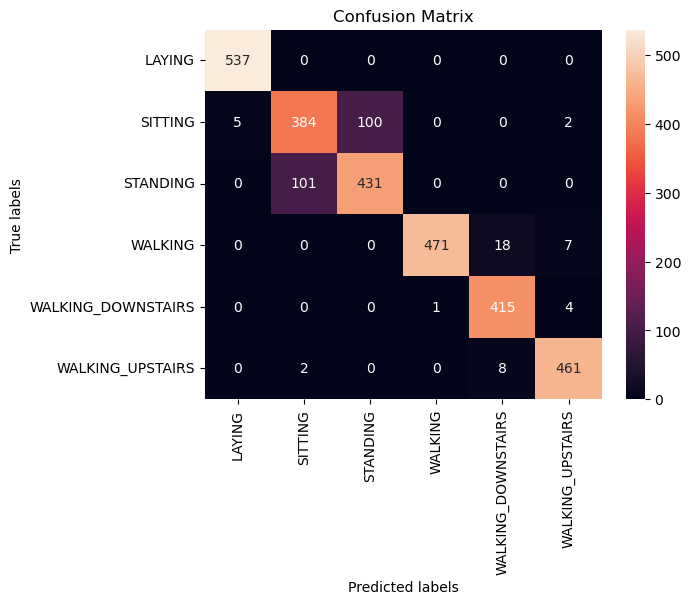

In [ ]:
import seaborn as sns
ax = plt.subplot()


#cm = confusion_matrix(np.asarray(Y_test).argmax(axis=1), np.asarray(y_pred).argmax(axis=0))
cm = confusion_matrix(Y_test, model.predict(X_test))
sns.heatmap(cm, annot=True, fmt='g',ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

In [ ]:
score = model.evaluate(X_test, Y_test)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)

93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.8779 - loss: 0.2940

   cat_crossentropy  ||   accuracy 
  ____________________________________
[0.22493654489517212, 0.9158466458320618]


<html><h1><p style="color:red">Defining the Architecture of 4-Layer of LSTM with more hyperparameter tunning </p></h1></html>

In [ ]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(timesteps, input_dim)))  # returns a sequence of vectors of dimension 32
model.add(BatchNormalization())
model.add(Dropout(0.50))
model.add(LSTM(64, return_sequences=True))  # returns a sequence of vectors of dimension 32
model.add(Dropout(0.50))
model.add(LSTM(64, return_sequences=True))  # return a single vector of dimension 32
model.add(Dropout(0.50))
model.add(LSTM(64,))  # return a single vector of dimension 32
model.add(Dropout(0.50))
model.add(Dense(n_classes, activation='softmax'))
model.summary()

C:\Users\SUBRAMANYAM\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 128, 64)        │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 128, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 128, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,662 (463.52 KB)

 Trainable params: 118,534 (463.02 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:

# Training the model
model.fit(X_train, Y_train, batch_size=n_batch, validation_data=(X_test, Y_test), epochs=n_epochs)

Epoch 1/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 115s 226ms/step - accuracy: 0.6968 - loss: 0.7835 - val_accuracy: 0.8521 - val_loss: 0.5413
Epoch 2/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 101s 220ms/step - accuracy: 0.9086 - loss: 0.2423 - val_accuracy: 0.8972 - val_loss: 0.4016
Epoch 3/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 1892s 4s/step - accuracy: 0.9301 - loss: 0.1877 - val_accuracy: 0.9002 - val_loss: 0.3483
Epoch 4/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 96s 209ms/step - accuracy: 0.9311 - loss: 0.1839 - val_accuracy: 0.9080 - val_loss: 0.3143
Epoch 5/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 102s 222ms/step - accuracy: 0.9265 - loss: 0.1945 - val_accuracy: 0.8823 - val_loss: 0.4115
Epoch 6/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 407s 887ms/step - accuracy: 0.9297 - loss: 0.1716 - val_accuracy: 0.9053 - val_loss: 0.3227
Epoch 7/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 103s 225ms/step - accuracy: 0.9336 - loss: 0.1617 - val_accuracy: 0.8751 - val_loss: 0.5080
Epoch 8/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 204s 443ms/step - accuracy: 0.9398 - lo

93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step


Text(0.5, 1.0, 'Confusion Matrix')

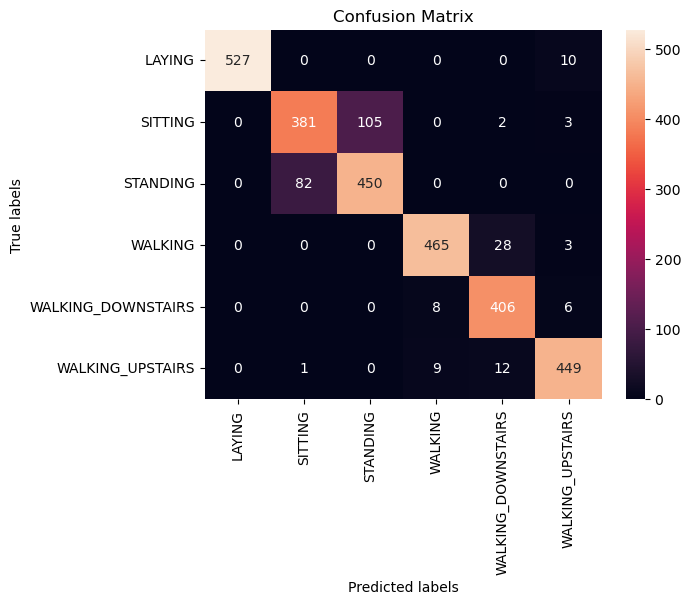

In [ ]:
import seaborn as sns
ax = plt.subplot()


#cm = confusion_matrix(np.asarray(Y_test).argmax(axis=1), np.asarray(y_pred).argmax(axis=0))
cm = confusion_matrix(Y_test, model.predict(X_test))
sns.heatmap(cm, annot=True, fmt='g',ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

In [ ]:
score = model.evaluate(X_test, Y_test)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)

93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8698 - loss: 0.4630

   cat_crossentropy  ||   accuracy 
  ____________________________________
[0.3721782863140106, 0.9087207317352295]


# <html><h1><p style="color:red">Defining the Architecture of 5-Layer of LSTM with more hyperparameter tunning </p></h1></html>

In [ ]:
model = Sequential()
model.add(LSTM(80, return_sequences=True, input_shape=(timesteps, input_dim)))
model.add(BatchNormalization())
model.add(Dropout(0.50))
model.add(LSTM(80, return_sequences=True))
model.add(Dropout(0.50))
model.add(LSTM(80, return_sequences=True))
model.add(Dropout(0.50))
model.add(LSTM(80, return_sequences=True))
model.add(Dropout(0.50))
model.add(LSTM(80,))
model.add(Dropout(0.50))
model.add(Dense(n_classes, activation='softmax'))
model.summary()

C:\Users\SUBRAMANYAM\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 128, 80)        │        28,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 80)        │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 128, 80)        │        51,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 128, 80)        │        51,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 128, 80)        │        51,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 80)             │        51,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           486 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,686 (920.65 KB)

 Trainable params: 235,526 (920.02 KB)

 Non-trainable params: 160 (640.00 B)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
# Training the model
model.fit(X_train, Y_train, batch_size=n_batch, validation_data=(X_test, Y_test), epochs=n_epochs)

Epoch 1/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 108s 222ms/step - accuracy: 0.6696 - loss: 0.8350 - val_accuracy: 0.8609 - val_loss: 0.4743
Epoch 2/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 96s 209ms/step - accuracy: 0.8993 - loss: 0.2926 - val_accuracy: 0.8955 - val_loss: 0.3244
Epoch 3/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 139s 202ms/step - accuracy: 0.9113 - loss: 0.2665 - val_accuracy: 0.9148 - val_loss: 0.2783
Epoch 4/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 94s 204ms/step - accuracy: 0.9295 - loss: 0.1894 - val_accuracy: 0.9002 - val_loss: 0.2718
Epoch 5/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 95s 207ms/step - accuracy: 0.9236 - loss: 0.2100 - val_accuracy: 0.8999 - val_loss: 0.2993
Epoch 6/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 95s 208ms/step - accuracy: 0.9377 - loss: 0.1605 - val_accuracy: 0.9013 - val_loss: 0.4271
Epoch 7/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 141s 204ms/step - accuracy: 0.9126 - loss: 0.2388 - val_accuracy: 0.8839 - val_loss: 0.3873
Epoch 8/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 96s 208ms/step - accuracy: 0.9233 - loss

93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step


Text(0.5, 1.0, 'Confusion Matrix')

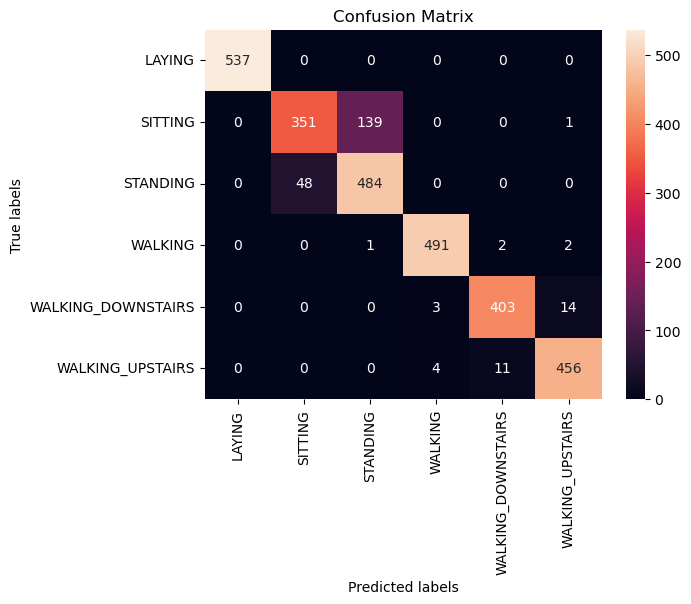

In [ ]:
import seaborn as sns
ax = plt.subplot()


#cm = confusion_matrix(np.asarray(Y_test).argmax(axis=1), np.asarray(y_pred).argmax(axis=0))
cm = confusion_matrix(Y_test, model.predict(X_test))
sns.heatmap(cm, annot=True, fmt='g',ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')






In [ ]:
score = model.evaluate(X_test, Y_test)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)

93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.8925 - loss: 0.2647

   cat_crossentropy  ||   accuracy 
  ____________________________________
[0.22656770050525665, 0.9236511588096619]


# <html><h1><p style="color:red">Defining the Architecture of 6-Layer of LSTM with more hyperparameter tunning </p></h1></html>

In [ ]:
model = Sequential()
model.add(LSTM(80, return_sequences=True, input_shape=(timesteps, input_dim)))
model.add(BatchNormalization())
model.add(Dropout(0.50))
model.add(LSTM(80, return_sequences=True))
model.add(Dropout(0.50))
model.add(LSTM(80, return_sequences=True))
model.add(Dropout(0.50))
model.add(LSTM(80, return_sequences=True))
model.add(Dropout(0.50))
model.add(LSTM(80, return_sequences=True))  # Add a new LSTM layer with return_sequences=True
model.add(Dropout(0.50))
model.add(LSTM(80,))  # The last LSTM layer without return_sequences
model.add(Dropout(0.50))
model.add(Dense(n_classes, activation='softmax'))
model.summary()

C:\Users\SUBRAMANYAM\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 128, 80)        │        28,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 80)        │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 128, 80)        │        51,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 128, 80)        │        51,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 128, 80)        │        51,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 128, 80)        │        51,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 80)             │        51,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │           486 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 287,206 (1.10 MB)

 Trainable params: 287,046 (1.09 MB)

 Non-trainable params: 160 (640.00 B)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:

# Training the model
model.fit(X_train, Y_train, batch_size=n_batch, validation_data=(X_test, Y_test), epochs=n_epochs)

Epoch 1/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 127s 261ms/step - accuracy: 0.6060 - loss: 0.9390 - val_accuracy: 0.8331 - val_loss: 0.6203
Epoch 2/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 117s 254ms/step - accuracy: 0.8810 - loss: 0.3858 - val_accuracy: 0.7645 - val_loss: 0.5526
Epoch 3/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 122s 264ms/step - accuracy: 0.7655 - loss: 0.5048 - val_accuracy: 0.7560 - val_loss: 1.2990
Epoch 4/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 130s 284ms/step - accuracy: 0.8910 - loss: 0.3258 - val_accuracy: 0.8945 - val_loss: 0.3154
Epoch 5/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 129s 256ms/step - accuracy: 0.9270 - loss: 0.2006 - val_accuracy: 0.8806 - val_loss: 0.3950
Epoch 6/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 119s 259ms/step - accuracy: 0.9321 - loss: 0.2035 - val_accuracy: 0.8622 - val_loss: 0.4244
Epoch 7/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 117s 254ms/step - accuracy: 0.8976 - loss: 0.2481 - val_accuracy: 0.8965 - val_loss: 0.3071
Epoch 8/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 135s 240ms/step - accuracy: 0.9245 -

93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step


Text(0.5, 1.0, 'Confusion Matrix')

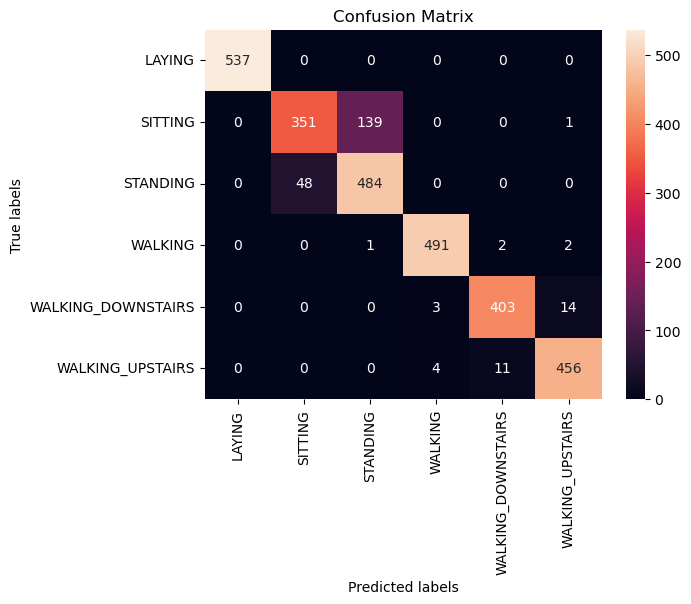

In [ ]:
import seaborn as sns
ax = plt.subplot()


#cm = confusion_matrix(np.asarray(Y_test).argmax(axis=1), np.asarray(y_pred).argmax(axis=0))
cm = confusion_matrix(Y_test, model.predict(X_test))
sns.heatmap(cm, annot=True, fmt='g',ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')


In [ ]:
score = model.evaluate(X_test, Y_test)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)

93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.8925 - loss: 0.2647

   cat_crossentropy  ||   accuracy 
  ____________________________________
[0.22656770050525665, 0.9236511588096619]


# <html><h1><p style="color:red">Defining the Architecture of 7-Layer of LSTM with more hyperparameter tunning </p></h1></html>

In [ ]:
model = Sequential()
model.add(LSTM(80, return_sequences=True, input_shape=(timesteps, input_dim)))
model.add(BatchNormalization())
model.add(Dropout(0.50))
model.add(LSTM(80, return_sequences=True))
model.add(Dropout(0.50))
model.add(LSTM(80, return_sequences=True))
model.add(Dropout(0.50))
model.add(LSTM(80, return_sequences=True))
model.add(Dropout(0.50))
model.add(LSTM(80, return_sequences=True))
model.add(Dropout(0.50))
model.add(LSTM(80, return_sequences=True))  # Add another LSTM layer with return_sequences=True
model.add(Dropout(0.50))
model.add(LSTM(80,))  # The last LSTM layer without return_sequences
model.add(Dropout(0.50))
model.add(Dense(n_classes, activation='softmax'))
model.summary()

C:\Users\SUBRAMANYAM\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                  │ (None, 128, 80)        │        28,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 80)        │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 128, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 128, 80)        │        51,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 128, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, 128, 80)        │        51,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 128, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 128, 80)        │        51,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 128, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 128, 80)        │        51,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 128, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 128, 80)        │        51,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 128, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 80)             │        51,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           486 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 338,726 (1.29 MB)

 Trainable params: 338,566 (1.29 MB)

 Non-trainable params: 160 (640.00 B)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Training the model
model.fit(X_train, Y_train, batch_size=n_batch, validation_data=(X_test, Y_test), epochs=n_epochs)

Epoch 1/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 134s 268ms/step - accuracy: 0.5337 - loss: 1.0060 - val_accuracy: 0.5137 - val_loss: 0.7962
Epoch 2/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 124s 269ms/step - accuracy: 0.5053 - loss: 0.8658 - val_accuracy: 0.5063 - val_loss: 0.7934
Epoch 3/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 128s 279ms/step - accuracy: 0.5562 - loss: 0.7793 - val_accuracy: 0.5558 - val_loss: 0.8775
Epoch 4/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 128s 278ms/step - accuracy: 0.6511 - loss: 0.6052 - val_accuracy: 0.6563 - val_loss: 0.5231
Epoch 5/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 132s 287ms/step - accuracy: 0.6426 - loss: 0.5637 - val_accuracy: 0.4886 - val_loss: 0.8963
Epoch 6/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 131s 285ms/step - accuracy: 0.4844 - loss: 0.8600 - val_accuracy: 0.4876 - val_loss: 0.9227
Epoch 7/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 131s 285ms/step - accuracy: 0.5985 - loss: 0.7151 - val_accuracy: 0.7323 - val_loss: 0.5321
Epoch 8/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 131s 286ms/step - accuracy: 0.7268 -

93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step


Text(0.5, 1.0, 'Confusion Matrix')

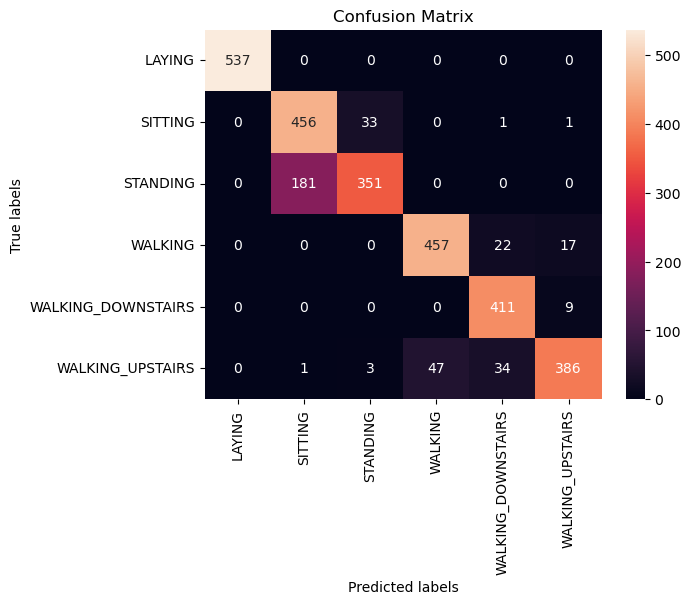

In [ ]:
import seaborn as sns
ax = plt.subplot()


#cm = confusion_matrix(np.asarray(Y_test).argmax(axis=1), np.asarray(y_pred).argmax(axis=0))
cm = confusion_matrix(Y_test, model.predict(X_test))
sns.heatmap(cm, annot=True, fmt='g',ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

In [ ]:
score = model.evaluate(X_test, Y_test)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)

93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.8824 - loss: 0.4161

   cat_crossentropy  ||   accuracy 
  ____________________________________
[0.4855074882507324, 0.8815745115280151]


In [ ]:
model.save("Human_Activity_Recognition.h5")